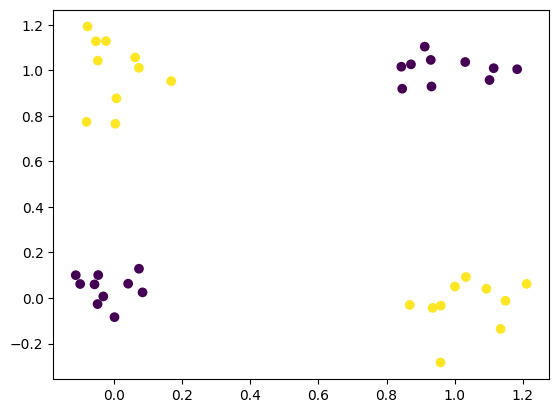

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs

def plot_dataset(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y)


def plot_hyperplane(vector, intercept=0, dataset=None):
    xs = np.array([0, 1])
    ys = -(vector[0] * xs + intercept) / vector[1]
    plt.plot(xs, ys, 'r-')

def sign(a):
    return (a >= 0) * 2 - 1


def create_dataset(n=40, func=lambda a, b: bool(a) != bool(b)):
    X, y = make_blobs(n_samples=n, centers=[[0, 0], [1, 0], [1, 1], [0, 1]], cluster_std=0.1)
    y = np.array([func(a > 0.5, b > 0.5) for a, b in zip(X[:, 0], X[:, 1])], dtype=int) * 2 - 1
    return X, y

X, y = create_dataset()

plot_dataset(X, y)
plt.show()

In [2]:
from scipy.special import expit

include_bias = lambda X: np.c_[np.ones(X.shape[0]), X]  # Add bias column to input matrix

def tanh(a):
    return expit(a) * 2 - 1  # Convert sigmoid output to tanh range

def get_axes_limits(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1 - offset, max1 + offset, min2 - offset, max2 + offset]

def plot_predictions(clf, X):
    axes = get_axes_limits(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X_grid = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X_grid).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

### MultiLayer Neural Network with Backpropagation

This code implements a flexible multi-layer neural network (also known as a Multi-Layer Perceptron or MLP) for binary classification. This implementation can handle multiple hidden layers of varying sizes.

- **Class Definition**:  
  `MultiLayer` inherits from `BaseEstimator` and `ClassifierMixin` for compatibility with scikit-learn utilities.

- **__init__**:  
  Initializes the model with:
  - `max_iter`: Number of training iterations (epochs)
  - `learning_rate`: Step size for weight updates
  - `n_hidden`: List specifying the number of neurons in each hidden layer (e.g., `[4, 3]` creates two hidden layers with 4 and 3 neurons respectively)

- **forward**:  
  - Stores activations (`A`) and pre-activations (`Z`) for backpropagation
  - For each layer's weights in `self.Ws`:
    - Adds bias to the current layer's input
    - Computes pre-activation (`Z`) by matrix multiplication
    - Applies tanh activation function to get the layer's output
    - Passes the output as input to the next layer
  - Returns the final layer's output (predictions)

- **backward**:  
  Implements backpropagation algorithm:
  - Calculates output error (`output_delta = y - ypred`)
  - Computes gradients for the output layer
  - **Backward propagation through hidden layers**:
    - For each hidden layer (from last to first):
      - Computes tanh derivative: `1 - tanh²(z)`
      - Propagates error backwards through weights (excluding bias weights)
      - Multiplies by activation derivative to get layer's error signal
      - Computes gradients for current layer's weights
  - **Weight updates**: Updates all weight matrices using computed gradients and learning rate

- **fit**:  
  - Initializes weight matrices (`self.Ws`) for all layers:
    - Each weight matrix connects one layer to the next
    - Includes bias weights (hence `previous_output + 1`)
    - Weights are randomly initialized between -1 and 1
  - Reshapes target labels if needed
  - Runs training loop for `max_iter` iterations, performing forward and backward passes

- **predict**:  
  - Runs forward pass on new data
  - Applies sign function to convert continuous outputs to binary class labels (+1 or -1)


1.0


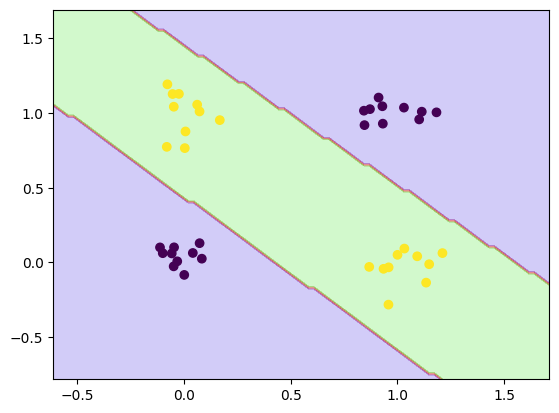

In [15]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class MultiLayer(BaseEstimator, ClassifierMixin):
  def __init__(self, max_iter=1000, learning_rate=0.01, n_hidden=[2]):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.n_hidden = n_hidden

  def forward(self, X):
    self.A = []
    self.Z = []
    AUX = X.copy()
    for W in self.Ws:
      self.A.append(include_bias(AUX))
      self.Z.append(self.A[-1] @ W)
      AUX = tanh(self.Z[-1])
    return AUX

  def backward(self, Xb, y, ypred):
    grads = []
    output_delta = y - ypred
    grads.insert(0, self.A[-1].T @ output_delta)
    for i in range(len(self.Ws)-1, 0, -1):
      tanh_grad = (1 - np.square(tanh(self.Z[i-1])))
      input_delta = (output_delta @ self.Ws[i][1:, :].T) * tanh_grad
      grads.insert(0, self.A[i-1].T @ input_delta)
      output_delta = input_delta.copy()
    for i in range(len(self.Ws)-1, -1, -1):
      self.Ws[i] += grads[i] * self.learning_rate

  def fit(self, X, y):
    self.Ws = []
    previous_output = X.shape[1]
    for layer_size in self.n_hidden:
      self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, layer_size)))
      previous_output = layer_size
    if len(y.shape) == 1:
      y = y.reshape(-1, 1)
    self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, y.shape[1])))
    for _ in range(self.max_iter):
      ypred = self.forward(X)
      self.backward(X, y, ypred)
    return self

  def predict(self, X):
    ypred = self.forward(X)
    return sign(ypred)

model = MultiLayer()
model.fit(X, y)
print(accuracy_score(y, model.predict(X)))
plot_predictions(model, X)
plot_dataset(X, y)
plt.show()

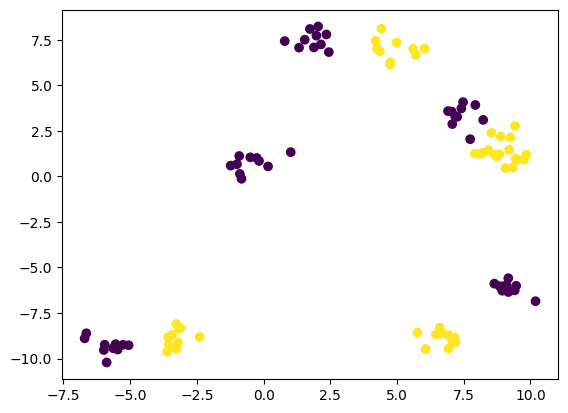

In [16]:
def create_hard_dataset(n=100, centers=10, std=0.5):
  X, y = make_blobs(n_samples=n, centers=centers, cluster_std=std)
  y = sign(np.array(y%2, dtype=int)*2-1)
  return X, y

X, y = create_hard_dataset()

plot_dataset(X, y)
plt.show()

0.99


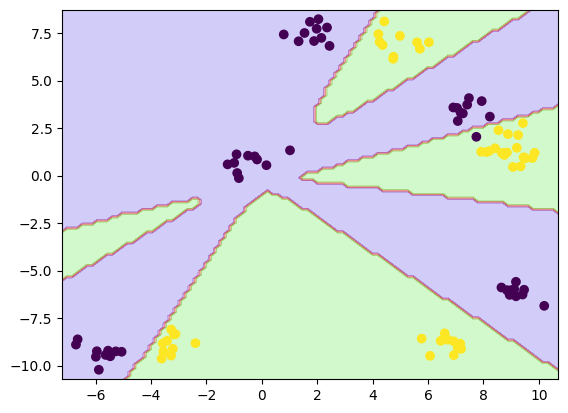

In [62]:
model = MultiLayer(n_hidden=[32,16])
model.fit(X, y)
print(accuracy_score(y, model.predict(X)))
plot_predictions(model, X)
plot_dataset(X, y)
plt.show()

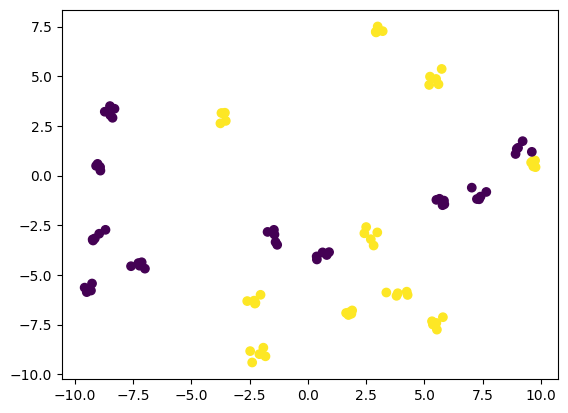

In [63]:
X, y = create_hard_dataset(centers=20, std=0.2)
plot_dataset(X, y)
plt.show()

1.0


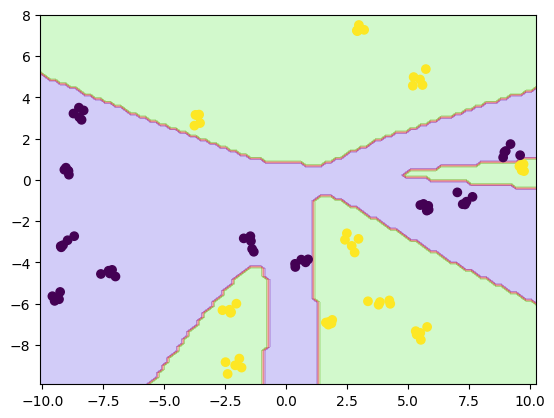

In [82]:
model = MultiLayer(n_hidden=[32,16])
model.fit(X, y)
print(accuracy_score(y, model.predict(X)))
plot_predictions(model, X)
plot_dataset(X, y)
plt.show()